In [3]:
from numpy.random import normal
import numpy as np
from numpy.linalg import inv

from scipy import *
from scipy.linalg import norm, pinv
 

from sympy import symbols, diff
import matplotlib.pyplot as plt



In [4]:
def kmeans(x,k):
    n = x.shape[0]
    n_iterations = 1000
    epsilon = 1e-8
    err = np.inf

    #initialize random centroids
    c = np.zeros((k,2))
    for i in range(k):
        idx = np.random.randint(n)
        c[i] = x[idx,:]

    for iteration in range(n_iterations):
        d = np.zeros((n, k))  # distances to centroids square
        for i in range(k):
            d[:, i] = np.sqrt(np.sum(np.square(np.subtract(x, np.tile(c[i, :], (n, 1)))), 1).flatten())

        #assign each point to nearest centroid
        l = np.argmin(d,1)


        #recompute centroids as center of mass of each cluster
        for j in range(k):
            if len(l[l==j]):
                c[j,:] = x[l==j].sum(0) / len(l[l==j])

        err_new = np.sum(np.min(d,1))/n


        if np.abs(err_new - err)<epsilon:
            break
        err = err_new

    return c,l,err

In [5]:
def factor_analysis(X,m):
    #X is a d*n data matrix
    #m : dimension of target space (i.e reduced space)
    d = X.shape[0]
    n = X.shape[1]
    
    mu = np.mean(X, axis = 1)
    
    
    print(d)
    print(n)
    #Mu = dot(mu, np.ones((n,),"float"))
    
    CenteredData = X

    for i in range(n):
        for j in range(d):
            CenteredData[j,i] = X[j,i]-mu[j]
        
    
    #The tolerance value
    tol = 1e-4
    
    #Maximum number of iteration
    maxiter = 50
    
    #Log-likelihood value
    llh = -1
    
    #Define identity matrix 
    I = np.identity(m)
    
    M = dot(CenteredData, np.transpose(CenteredData))
    r = M.diagonal()
    
    #Initialize the weight matrix
    W = np.random.rand(d,m)
    Wupdated = W
    
    #Psi is the diagonal covariance matrix, we store only a d-dimensional vector
    Psi = np.identity(d)
    
    for i in  range(d):
        Psi[i,i] = random.random()
    
    Psiupdated = Psi
    
    for iter in range(maxiter-1):
        Psi = Psiupdated
        W = Wupdated
        G = inv(I + dot(dot(np.transpose(W),inv(Psi)),W))
        R = dot(dot(np.transpose(W), inv(Psi)),CenteredData)
        
        #E-step
        Ez = dot(G,R)
        Ezz = G + dot(Ez, np.transpose(Ez))
        
        #M-step
        DataCovariance = np.cov(CenteredData)
        
        #Updated weights
        Wupdated = dot(CenteredData, np.transpose(Ez))
        Wupdated = dot(Wupdated, inv(Ezz))
        
        #Updated Psi
        V = np.diag(DataCovariance - (1/n)**dot(Wupdated,dot(Ez,np.transpose(CenteredData))))
        Psiupdated = np.diag(V)
        #print(Psiupdated)
        
        
    L = [mu,Wupdated,Psiupdated]
    
    return L
    

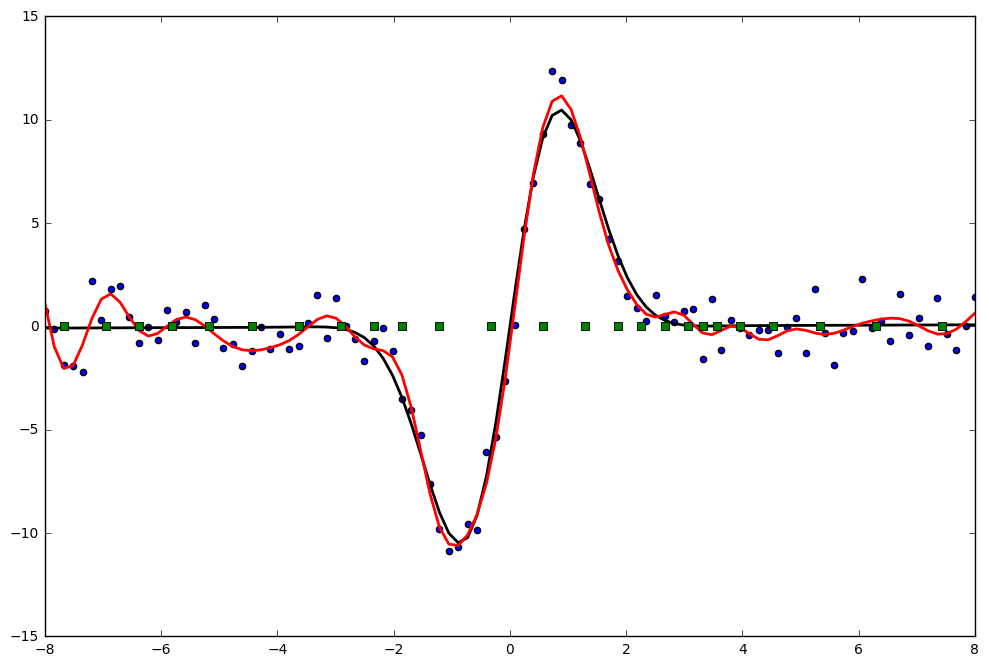

In [12]:
n = 100

#Specify Dimension of inputs and outputs
InputDimension = 1
OutputDimension = 1
     
#Define the bound of the focused interval    
lbound = -8
ubound = 8
    
x = mgrid[lbound:ubound:complex(0,n)].reshape(n, 1)
# set y and add random noise
    
    
#Function 1
yOriginal = 0.01*x+20*np.sin(x)*np.exp(-x**2/2)

# function 2 : Well
#yOriginal = 0.9*x-50*np.exp(-x**2/2)+1

yNoisy = yOriginal + random.normal(0, 1, yOriginal.shape)

     
#Initialize parameters of the radial basis function
    
#Number of Gaussian centers(Neurons)
numNeurons = 25

#Define the size of the kernels 
beta = 1

######### Start RBF regression #############

#Train the neural network on the data x
parameters = trainrbf(x, yNoisy , beta, numNeurons)
z = testrbf(x, parameters[0], parameters[1], beta, numNeurons, parameters[2])

z = np.mean(z,1)

# plot original data
plt.figure(figsize=(12, 8))

# plot original data
plt.plot(x,yOriginal, 'k-', linewidth=2)

for i in range(n):
    plt.scatter(x[i], yNoisy[i])
     
# plot learned model
plt.plot(x, z, 'r-', linewidth=2)
     
# plot rbfs
plt.plot(parameters[2], zeros(numNeurons), 'gs')
     
plt.xlim(lbound, ubound)
plt.show()

#plt.savefig('graphs/RBF_2.jpg', format = 'jpg')

In [6]:
np.random.seed(0)


#radial basis function compute exp(-beta * (c-x)^2)
def radialbasisfunc(beta, c, x):
    return exp(-beta * norm(c-x)**2)
     
#activation fills the Phi (in the pdf)
def activation(X, beta, numNeurons, centers):
    # calculate activations of RBFs
    Phi = zeros((X.shape[0], numNeurons), float)
    for i, c in enumerate(centers):
        for j, x in enumerate(X):
            #Here we fill the element j,i with exp(-beta * (c_i-x_j)^2)
            Phi[j,i] = radialbasisfunc(beta, c, x)
    return Phi
     
#trainrbf gives the values of the weights W and the covariance matrix Q
def trainrbf(X, Y, beta, numNeurons,verbose=0):
    
    #Dimensions
    #X: n x Inputdimension
    #y: n x 1
    
    #Centers are the neurons in our RBF network
    newCenters = kmeans(X,numNeurons)
    centers = newCenters[0]
    
    if verbose:
        print("centers", centers)
    
    # calculate activations of RBFs
    Phi = activation(X, beta, numNeurons, centers)
    Phi = np.append(Phi, X, axis =1)
    Phi = np.append(Phi, np.ones(X.shape, "float"), axis = 1)
        
    # calculate output weights (pseudoinverse)
    W = dot(pinv(Phi), Y)
    
    #Calculate the covariance matrix Q with formula (6.18) 
    Q = (dot(np.transpose(Y),Y) - dot(np.transpose(W), dot(np.transpose(Phi), Y)))
    
    L = [W, Q, centers]
    
    if verbose:
        print(W)
        print(Q)
    
    return L
         
def testrbf(X, W, Q, beta, numNeurons, centers):
    """ X: matrix of dimensions n x indim """
         
    Phi = activation(X, beta, numNeurons, centers)
    Phi = np.append(Phi, X, axis=1)
    Phi = np.append(Phi, np.ones((X.shape), "float"), axis=1)
    Y = dot(Phi, W) + (1/X.shape[0])*random.normal(0, Q, X.shape[0])
    return Y

